# DEM analysis
## low resolution DEM and landslides
This script runs through DEM analysis with the low resolution (8m) DEM from LINZ and the landslide inventory

This script does not include analysis of the LIDAR dems, or NDVI data. 

# DO NOT RUN on the jupyter hub
 the data is not on the jupyter hub and none of the paths will work and all figures will be reset

In [7]:
#import the packages
# Working with NZ dem and the NZ lidar data from different time periods
import os
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio
from rasterio import plot, mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
import matplotlib.pyplot as plt
import rasterstats
from rasterstats import zonal_stats
import rioxarray
from matplotlib_scalebar.scalebar import ScaleBar


import rasterio
from rasterio import features
from shapely.geometry import shape
from shapely.geometry import box


# would whitebox work now...
import whitebox_workflows

from whitebox_workflows import WbEnvironment
wbe = WbEnvironment()
wbe.verbose = False 

# Part 1 working with the 7m LINZ dem and the landslides


In [3]:
# Identify the file paths 
# first set up the base folder, should make it easier to move working directories/computers
data_base_folder='/Users/pmorgan/UW/class/gda/gdanzdata/'
demname='kaik_full'

# the LINZ 8m resolution dem
dem_fn=os.path.join(data_base_folder, f"kaik_full.tif")
dem_proj_fn=os.path.join(data_base_folder, f"kaik_full_utm.tif")

dst_crs = 'EPSG:32759' # working crs (above dem was already reprojected with gdal)


# The landslide file path

landslideshapepolyfn=os.path.join(data_base_folder, f"landslidepolys/Landslides.shp")


### Load the dem data into whitebox to work with


In [12]:
# Read in the DEM file.
dem = wbe.read_raster(dem_proj_fn) # This DEM file is contained in the downloaded data folder.
# Fill in nodata holes
dem = wbe.fill_missing_data(dem, filter_size=35, exclude_edge_nodata=True);
# smooth the dem for processing and imaging
dem = wbe.feature_preserving_smoothing(dem, filter_size=11, normal_diff_threshold=25.0, iterations=4) 
# these smoothing parameters are out of the whitebox tutorial, not sure if they are really the right ones to use


In [13]:
# create a hillshade image for visualization.
# This hillshade is way better than the gdal version!
hs_fn=os.path.join(data_base_folder, f"{demname}_hs.tif")
hs = wbe.multidirectional_hillshade(dem, full_360_mode=True)
wbe.write_raster(hs, hs_fn, compress=True)

<Axes: >

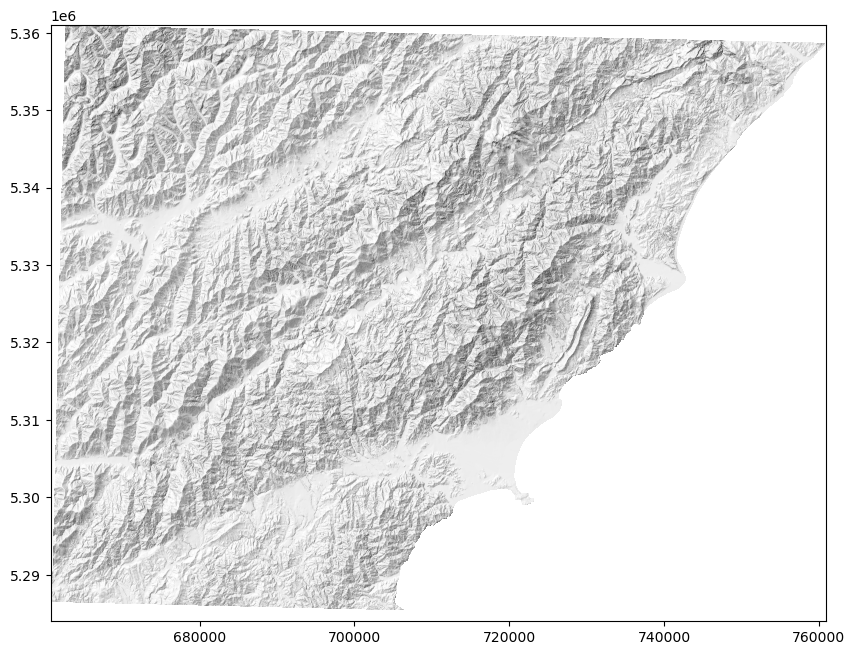

In [17]:
# plot the DEM to see what we're working with
#read the hillshade tiff with rasterio 
src_hs= rio.open(hs_fn)

fig,axa=plt.subplots(figsize=(10,10))
rio.plot.show(src_hs,ax=axa,cmap='gray')

### Calculate morphology parameters we want to extract at landslide points
Unfortunately the only way to get Whitebox and Geopandas to talk, is to save these outputs as separate tif files

In [20]:
# start with slope
slope_fn=os.path.join(data_base_folder, f"{demname}_slope.tif")
wb_slope = wbe.slope(dem)
wbe.write_raster(wb_slope, slope_fn, compress=True)


In [21]:
# then aspect
aspect_fn=os.path.join(data_base_folder, f"{demname}_aspect.tif")
wb_aspect = wbe.aspect(dem)
wbe.write_raster(wb_aspect, aspect_fn, compress=True)


In [25]:
# a complex roughness measure spherical_std_dev_of_normals
ssdn_5_fn=os.path.join(data_base_folder, f"{demname}_ssdn5.tif")
ssdn_5=wbe.spherical_std_dev_of_normals(dem, filter_size = 5)
wbe.write_raster(wb_aspect, ssdn_5_fn, compress=True)



In [26]:
# ruggedness or terrain ruggedness index TRI

tri_fn=os.path.join(data_base_folder, f"{demname}_tri.tif")
wb_tri = wbe.ruggedness_index(dem)
wbe.write_raster(wb_tri, tri_fn, compress=True)



### Load in the Landslide inventory


In [77]:
# load in and reproject the landslides
slide_gdf=gpd.read_file(landslideshapepolyfn)
slide_proj_gdf=slide_gdf.to_crs('EPSG:32759')

# clip just to the raster bounds
# get bounds of src
bounds  = src_hs.bounds
#geom = box(*bounds)
bounds_df= gpd.GeoDataFrame({"id":1,"geometry":[box(*bounds)]})
bounds_df=bounds_df.set_crs('epsg:32759')

slide_clip_gdf=gpd.clip(slide_proj_gdf, bounds_df, keep_geom_type=False)


### Extract the DEM values to the landslides

In [78]:
#order is read in the raster file with rasterio 
#  - make it a numpy array 
#  - rasterstats to extract mean at polygons 
#  -put those values in the slide gdf

with rio.open(slope_fn) as src:
    r_src=src.read(1)
    zonalstats = zonal_stats(slide_clip_gdf, raster=r_src, affine=src.transform, nodata=src.nodata,stats="mean")
    slide_clip_gdf['mean_slope'] = [stat['mean'] for stat in zonalstats] # chatgptcode...

with rio.open(aspect_fn) as src:
    r_src=src.read(1)
    zonalstats = zonal_stats(slide_clip_gdf, raster=r_src, affine=src.transform, nodata=src.nodata,stats="mean")
    slide_clip_gdf['mean_aspect'] = [stat['mean'] for stat in zonalstats] # chatgptcode...

with rio.open(ssdn_5_fn) as src:
    r_src=src.read(1)
    zonalstats = zonal_stats(slide_clip_gdf, raster=r_src, affine=src.transform, nodata=src.nodata,stats="mean")
    slide_clip_gdf['mean_ssdn_5'] = [stat['mean'] for stat in zonalstats] # chatgptcode...

with rio.open(tri_fn) as src:
    r_src=src.read(1)
    zonalstats = zonal_stats(slide_clip_gdf, raster=r_src, affine=src.transform, nodata=src.nodata,stats="mean")
    slide_clip_gdf['mean_tri'] = [stat['mean'] for stat in zonalstats] # chatgptcode...



# Part 2 flow routing and hillslope position of the landslides
Not super related to causes of reactivation, but something I'm very interested in!


### flow routing


In [82]:
import math # We'll use the log function below

# Remove the depressions, first by breaching the depressions using a max dist so that it doesn't
# carve excessively long trenches for very deep pits, and then filling the remaining depressions
dem_no_deps = wbe.breach_depressions_least_cost(dem, flat_increment=0.001, max_dist=100) # Change the max dist parameter as appropriate for your DEM
dem_no_deps = wbe.fill_depressions(dem_no_deps, flat_increment=0.001)

# Perform a flow-accumulation operation. Here I'm using the Qin (2007) multiple flow direction algorithm
# but there are many other options available, including D-infinity.
#
# Stream channels are usually identified as areas of relatively high flow accumulation and are mapped by thresholding
# flow accumulation values. Let's choose a threshold value.
channel_threshold = 25000.0 # this should be fine tuned, but isn't at this moment
#channel_threshold = 250000.0

flow_accum_fn=os.path.join(data_base_folder, f"{demname}_flow_accum.tif")
flow_accum = wbe.qin_flow_accumulation(dem_no_deps, out_type='cells', convergence_threshold=channel_threshold, log_transform=True)
wbe.write_raster(flow_accum, flow_accum_fn)

# Map the streams by thresholding the flow accum raster, using the same convergence threshold used above. This way
# we can be assured that the streams are single-cell wide D8 representation, which is needed for any stream
# network analysis operations.
streams = flow_accum > math.log(channel_threshold)


In [93]:
# We need a d8-pointer raster to be able to route flow through the network
d8_pntr = wbe.d8_pointer(dem_no_deps)

streams_fn=os.path.join(data_base_folder, f"{demname}_streams2.shp")
streams_vec = wbe.raster_streams_to_vector(streams, d8_pntr)
streams_vec, tmp1, tmp2, tmp3 = wbe.vector_stream_network_analysis(streams_vec, dem_no_deps) # We only want the streams output
wbe.write_vector(streams_vec, streams_fn)

In [95]:
#then load in the streams
#load in the streams as a gdf
#streams_fn="/Users/pmorgan/UW/class/gda/gdanzdata/streams2.shp"
streams_gdf=gpd.read_file(streams_fn)
streams_gdf.set_crs('epsg:32759')

FID       TUCL  MAXUPSDIST   MIN_ELEV   MAX_ELEV  OUTLET  HORTON  \
0        1   592.0727      0.0000   236.6898   252.9447      46       2   
1        2  1175.9058    592.0727   236.6668   236.6898      46       2   
2        3   563.1359      0.0000   222.2871   311.7243      45       1   
3        4   578.5754      0.0000   425.5606   476.0856      54       1   
4        5   361.3252      0.0000   236.6898   271.5126      46       1   
...    ...        ...         ...        ...        ...     ...     ...   
1632  1633  2111.7841   1147.5377   882.5261   894.1738      72       2   
1633  1634  1132.9027      0.0000   757.2691  1154.4147      65       1   
1634  1635  2162.7913      0.0000   700.9310   949.5529      62       1   
1635  1636   890.2667      0.0000   894.1738  1063.5261      72       1   
1636  1637  1293.8881      0.0000  1018.8043  1079.9698      65       3   

      STRAHLER  SHREVE  HACK  DIST2MOUTH  DS_NODES  IS_OUTLET  DS_LINK_ID  \
0            1       1     1    814.5805         1          0           1   
1            2       2     1    222.5077         0          1         -99   
2            1       1     1    563.1359         0          1         -99   
3            1       1     1    578.5754         0          1         -99   
4            1       1     2    583.8330         1          0           1   
...        ...     ...   ...         ...       ...        ...         ...   
1632         2       2     1     73.9796         0          1         -99   
1633         1       1     2   2826.7636         1          0        1382   
1634         1       1     2   3300.7161         1          0        1331   
1635         1       1     2    964.2463         1          0        1632   
1636         1       1     2  10173.9163         4          0        1628   

      MAINSTEM  TRIB_ID                                           geometry  
0            1        1  LINESTRING (685925.816 5285798.473, 685933.820...  
1            1        1  LINESTRING (686478.104 5285878.515, 686542.137...  
2            1        2  LINESTRING (697795.997 5285806.478, 697804.001...  
3            1        3  LINESTRING (682668.120 5286110.636, 682684.128...  
4            0      859  LINESTRING (686542.137 5286206.686, 686542.137...  
...        ...      ...                                                ...  
1632         1       82  LINESTRING (681891.715 5360517.380, 681883.711...  
1633         0      109  LINESTRING (669477.251 5359877.046, 669485.255...  
1634         0      118  LINESTRING (676560.940 5360133.180, 676568.944...  
1635         0       83  LINESTRING (682580.074 5360173.201, 682580.074...  
1636         0      110  LINESTRING (665699.284 5360669.459, 665707.288...  

[1637 rows x 17 columns]

<Axes: >

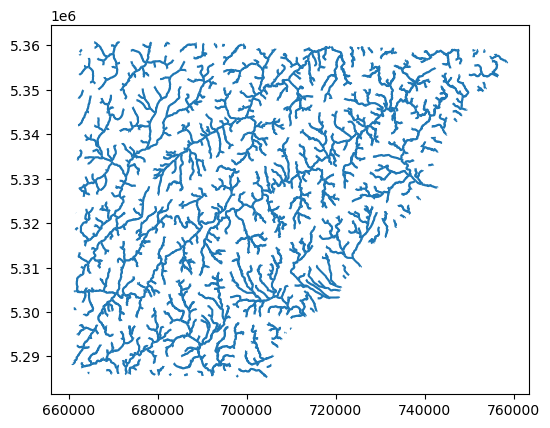

In [96]:
streams_gdf.plot()

In [86]:
# Extract all of the watersheds, draining to each outlet on the edge of the DEM using the 'basins' function.
basins_fn=os.path.join(data_base_folder, f"{demname}_basins.tif")
basins = wbe.basins(d8_pntr)
wbe.write_raster(basins, basins_fn)

# How about extracting subcatchments, i.e. the areas draining directly to each link in the stream network?
subcatchments_fn=os.path.join(data_base_folder, f"{demname}_subcatchments.tif")
subcatchments = wbe.subbasins(d8_pntr, streams)
wbe.write_raster(subcatchments, subcatchments_fn)


In [88]:
#convert the subcatchemnts into polygons
src_subcatchments= rio.open(subcatchments_fn)
SC_raster=src_subcatchments.read(1)

# Generate shapes
scpolyshapes = features.shapes(SC_raster, transform=src.transform)

# Convert shapes to polygons
#db_polygons = [shape(shape) for shape, value in dbpolyshapes if value != 0]
sc_polygons = [shape(ss) for ss, value in scpolyshapes if value != 0]

# Extract values for each polygon
#basin_values = [value for shape, value in dbpolyshapes if value != 0]
sc_values = [value for ss, value in scpolyshapes if value != 0]

# Create GeoDataFrame
sc_gdf = gpd.GeoDataFrame({ 'geometry': sc_polygons},crs="EPSG:32759")

# make the boundarys a lines dataset (Sub Catchement Outlines)
scoutlines=sc_gdf.boundary


In [89]:
# convert the landslide polygons to points located at the landslide cetroids
slide_points = slide_clip_gdf.copy()
# change geometry 
slide_points['geometry'] = slide_points['geometry'].centroid
#slide_points.head()

In [100]:
# get the distance from the slide centroids to the nearest river and ridge line
# not a very efficient looping distance plot from stackexchange

#be carefull this distance finding takes a long time

def min_distance(point, lines):
    return lines.distance(point).min()

slide_points['min_dist_to_ridges'] = slide_points.geometry.apply(min_distance, args=(scoutlines,))
slide_points['min_dist_to_rivers'] = slide_points.geometry.apply(min_distance, args=(streams_gdf,))



In [101]:
# from the minimum distances add in some normalized distances. 
slide_points['hillslopelengthestimate1'] =  slide_points.min_dist_to_ridges + slide_points.min_dist_to_rivers
slide_points['normalized_dist_river'] =   slide_points.min_dist_to_rivers /  slide_points.hillslopelengthestimate1
slide_points['normalized_dist_ridge'] =  slide_points.min_dist_to_ridges /  slide_points.hillslopelengthestimate1

Text(0, 0.5, 'slide count')

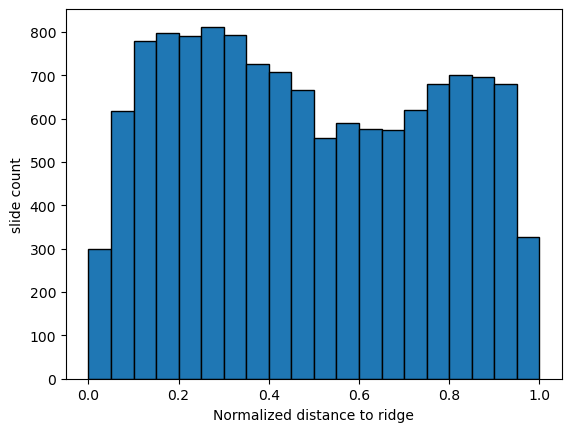

In [104]:
#plot a histogram of the normalized distance to the ridge or river
plt.hist(slide_points['normalized_dist_ridge'],bins=20,edgecolor="black")
plt.xlabel('Normalized distance to ridge')
plt.ylabel('slide count')

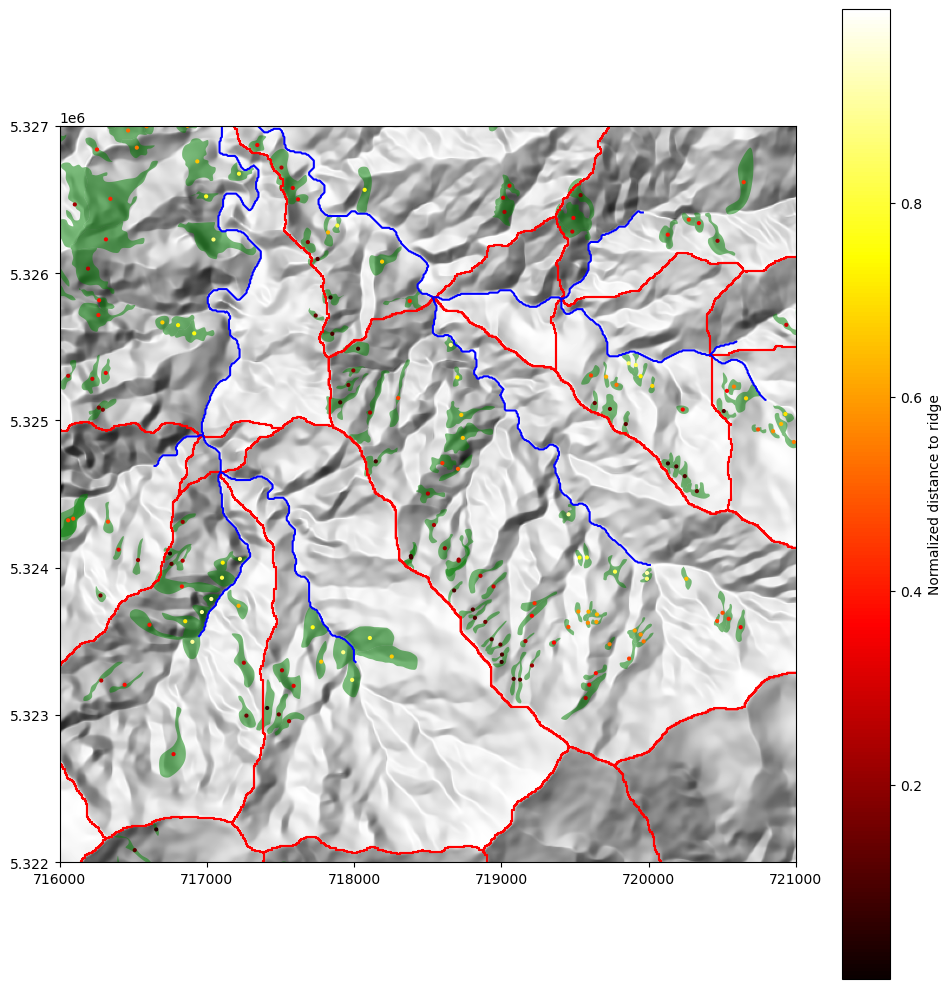

In [135]:
# plot river/ridge/normalize distance data

ex1_bounds_left=716000
ex1_bounds_right=721000
ex1_bounds_top=5327000
ex1_bounds_bottom=5322000

%matplotlib inline

fig,axa=plt.subplots(figsize=(10,10))
rio.plot.show(src_hs,ax=axa,cmap='gray')
#sc_gdf.plot(facecolor="none", edgecolor="red",ax=axa)
scoutlines.plot(color='red',ax=axa)
streams_gdf.plot(ax=axa,color='blue')
slide_clip_gdf.plot(ax=axa,facecolor="green",alpha=0.5)
slide_points.plot(ax=axa,markersize=4,column='normalized_dist_ridge',cmap='hot',legend=True,legend_kwds={"label": "Normalized distance to ridge"})
axa.set_xlim(left=ex1_bounds_left, right=ex1_bounds_right)
axa.set_ylim(bottom=ex1_bounds_bottom, top=ex1_bounds_top)

plt.tight_layout()

### plots of the flow routing process...

<Axes: >

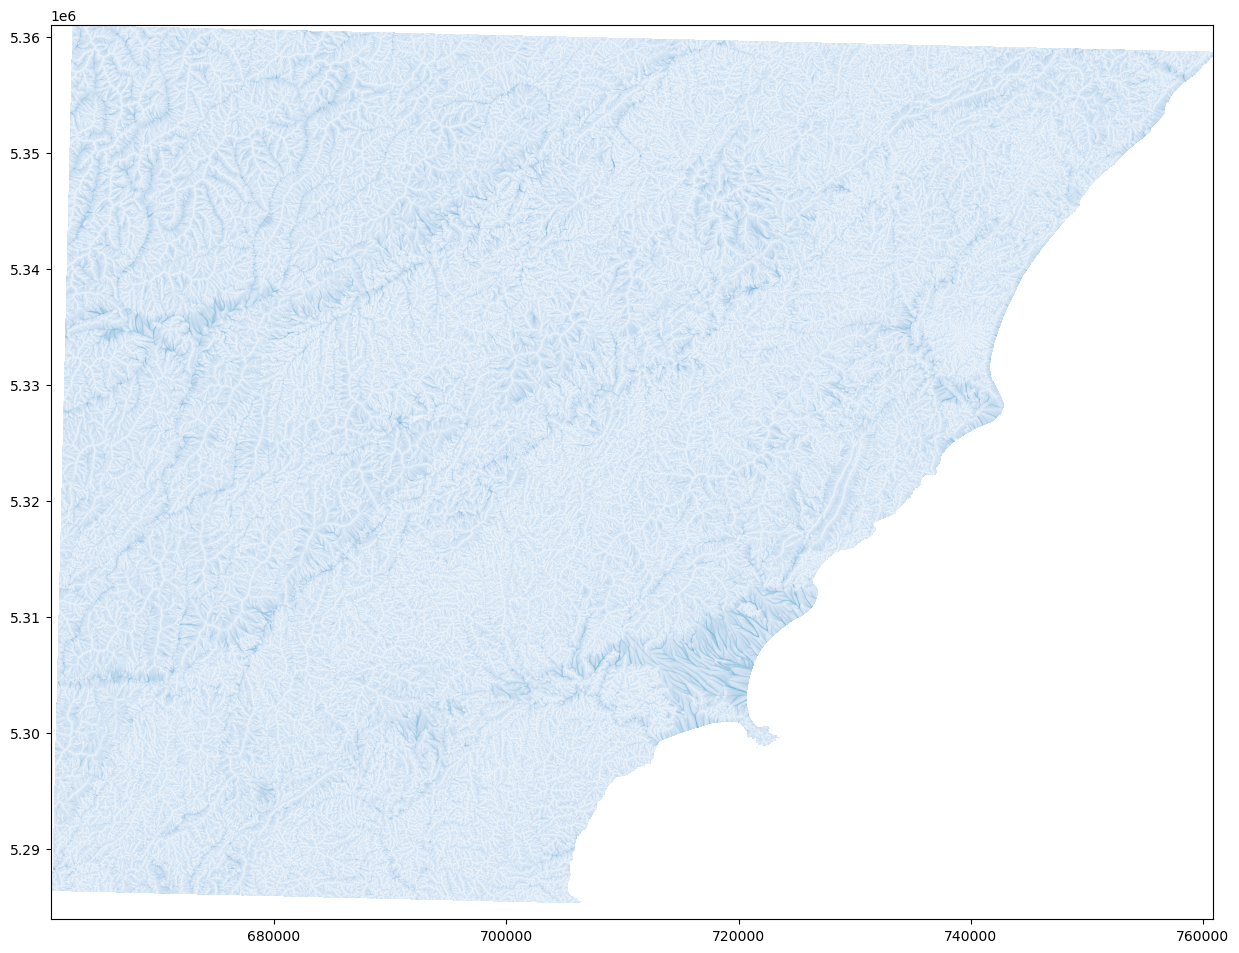

In [129]:
src_flow= rio.open(flow_accum_fn)

fig,axa=plt.subplots(figsize=(15,15))
rio.plot.show(src_flow,ax=axa,cmap='Blues',)
#slide_clip_gdf.plot(ax=axa,facecolor="green",alpha=0.5)


<Axes: >

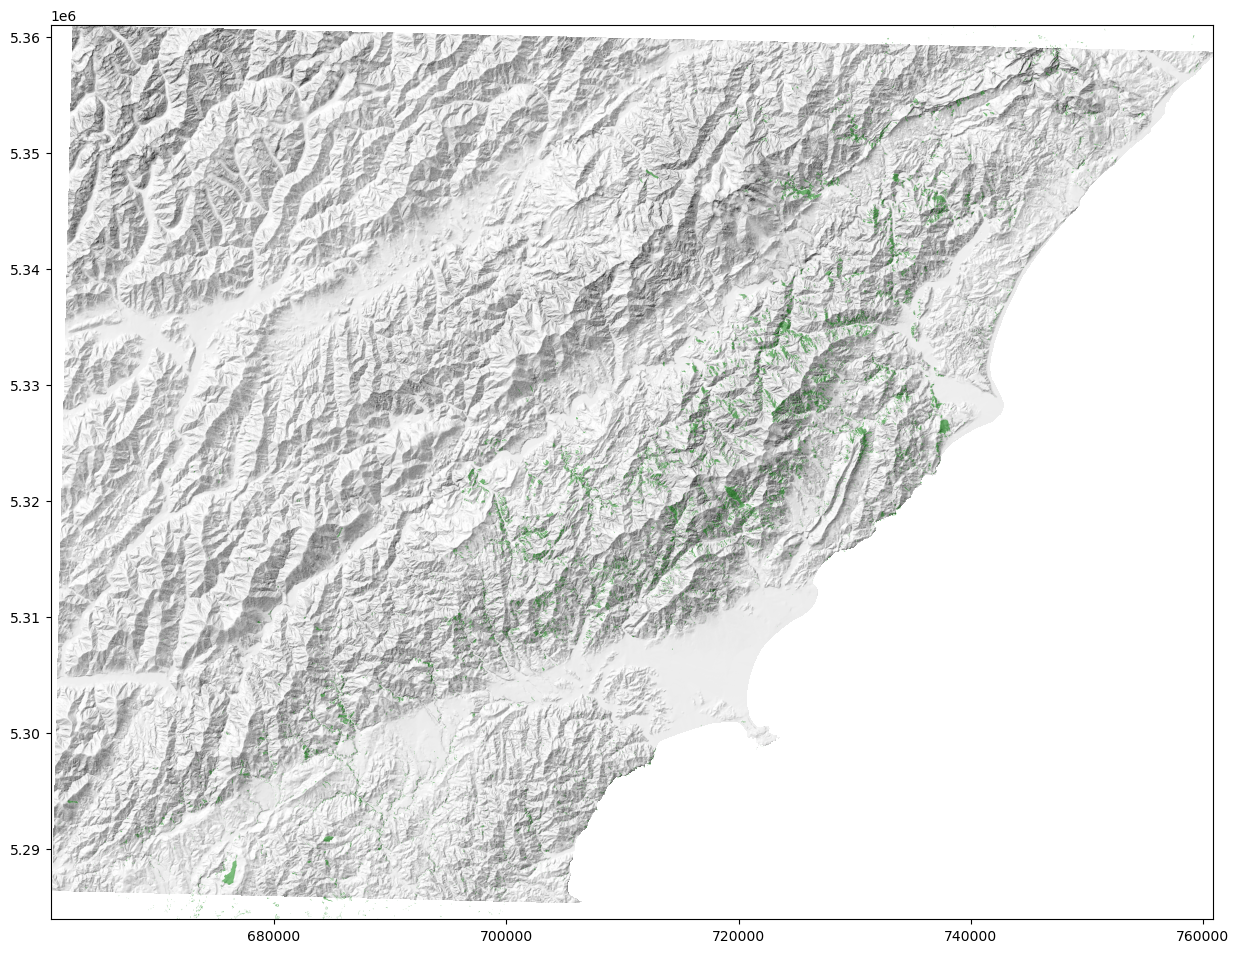

In [97]:
src_hs= rio.open(hs_fn)

fig,axa=plt.subplots(figsize=(15,15))
rio.plot.show(src_hs,ax=axa,cmap='gray')
slide_clip_gdf.plot(ax=axa,facecolor="green",alpha=0.5)


<Axes: >

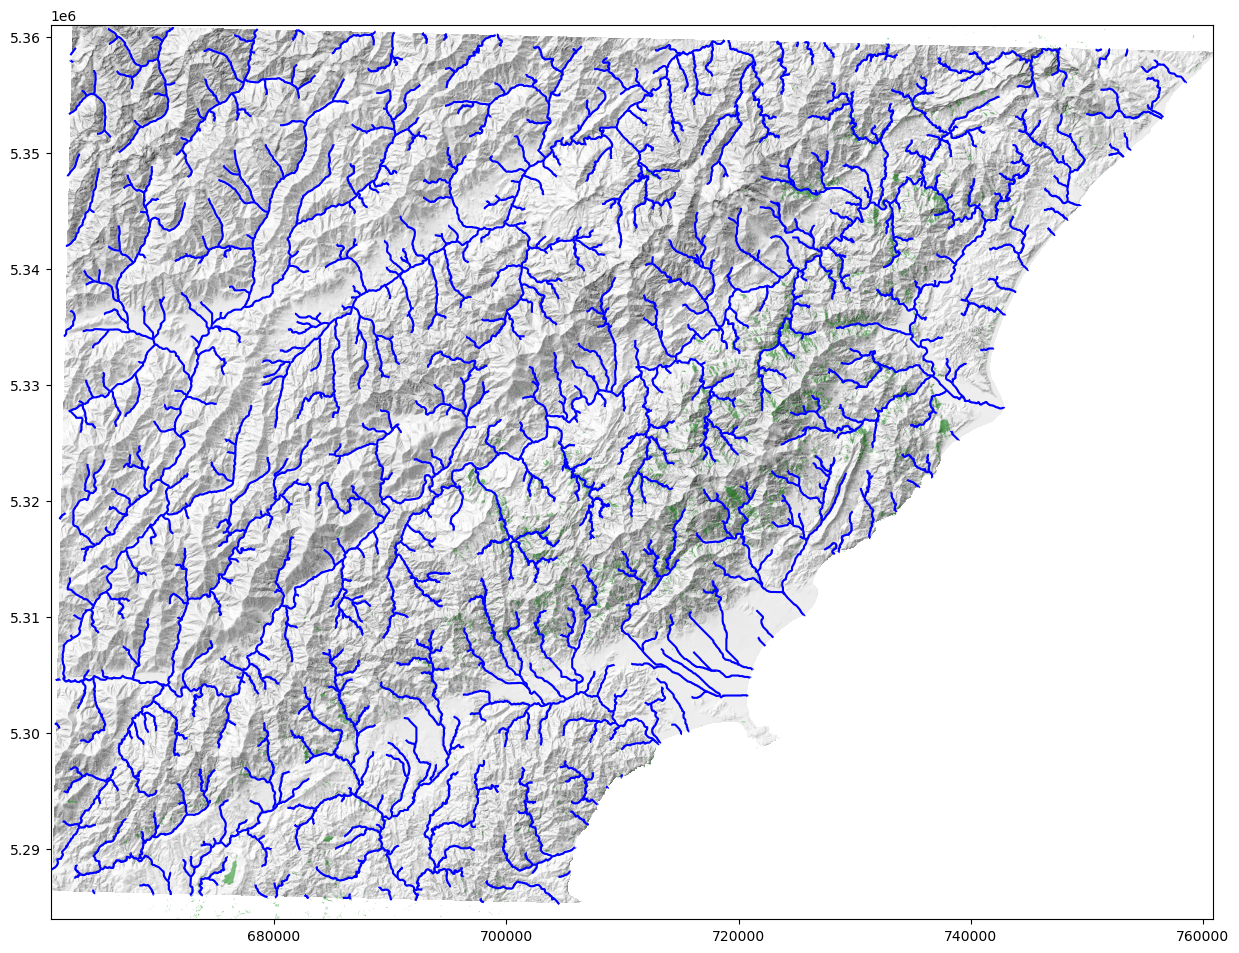

In [98]:
fig,axa=plt.subplots(figsize=(15,15))
rio.plot.show(src_hs,ax=axa,cmap='gray')
slide_clip_gdf.plot(ax=axa,facecolor="green",alpha=0.5)
streams_gdf.plot(ax=axa,color='blue')


<Axes: >

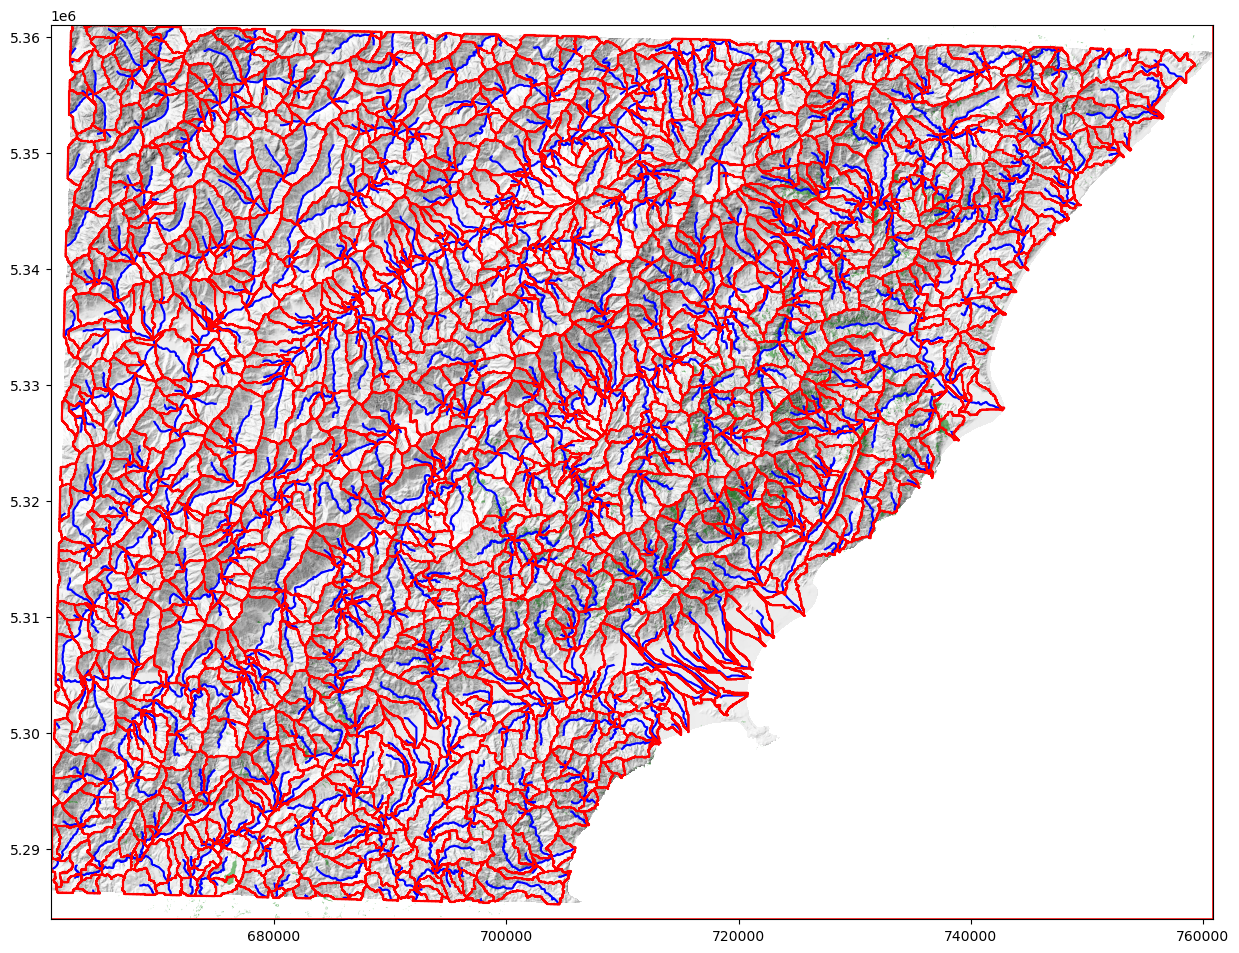

In [99]:
fig,axa=plt.subplots(figsize=(15,15))
rio.plot.show(src_hs,ax=axa,cmap='gray')
slide_clip_gdf.plot(ax=axa,facecolor="green",alpha=0.5)
streams_gdf.plot(ax=axa,color='blue')
scoutlines.plot(color='red',ax=axa)
